In [277]:
import os
import datetime
import pandas as pd
from sqlalchemy import create_engine
import psycopg2
from dotenv import load_dotenv
import urllib.parse
import matplotlib.pyplot as plt

load_dotenv()
POSTGRES_USERNAME = os.environ.get('JDB_USER')
POSTGRES_PASSWORD = os.environ.get('JDB_PASSWORD')
POSTGRES_ADDRESS = os.environ.get('JDB_HOST')
POSTGRES_PORT = 5432
POSTGRES_DBNAME = os.environ.get('JDB_NAME')
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME, password=POSTGRES_PASSWORD, ipaddress=POSTGRES_ADDRESS, port=POSTGRES_PORT, dbname=POSTGRES_DBNAME))
cnx = create_engine(postgres_str)

In [297]:
#
# Start by reading in information on all valid completed stays, including all charges.
# A stay is valid if it started after the first day data was collected (since we have
# no idea when stays started for those collected the first day).

query = """
select s.defendant_id,
    s.name,
    s.gender,
    s.race, s.start_date, s.end_date,
    CASE
		WHEN s.end_date IS NOT NULL THEN date_part('day'::text, s.end_date::timestamp without time zone - s.start_date::timestamp without time zone) + 1::double precision
		ELSE date_part('day'::text, CURRENT_DATE::timestamp without time zone - s.start_date::timestamp without time zone) + 1::double precision
	END AS days,
    c.level, 
    d.charge, d.description,
	case
		WHEN d.status = 'PRE-TRIAL' THEN 0
		ELSE 1
	END as nonpretrial,
	CASE
		WHEN d.bond_type = 'SECURED' AND bond_status = 'ACTI' THEN d.bond_amount
		ELSE 0
	END as sbond_amount,
	CASE
		WHEN d.bond_type = 'UNSECURED' AND bond_status = 'ACTI' THEN d.bond_amount
		ELSE 0
	END as ubond_amount,
	case
		WHEN d.bond_type = 'NO BOND' THEN 1
		ELSE 0
	END as nobond,
    c.class_type,
    c.violent, c.drugs, c.dwi, c.theft,
	c.violation, c.not_primary_custodian, c.min_level, c.max_level
    from stays s left join daily_charges d on s.defendant_id = d.defendant_id
    left join charge_definitions c on c.charge = d.charge
    where s.use_flag = 1 and s.start_date >= '2022-01-05' and s.start_date < '2023-01-05';
"""
stays = pd.read_sql_query(query, cnx)
stays.head(5)

,defendant_id,name,gender,race,start_date,end_date,days,level,charge,description,...,nobond,class_type,violent,drugs,dwi,theft,violation,not_primary_custodian,min_level,max_level
0,8740,"BLOUNT, JASON VALORR",M,B,2022-01-05,2022-01-05,1.0,7,14-87.1|1220|G,COMMON LAW ROBBERY,...,0,F,0,0,0,0,0,0,7,7
1,8740,"BLOUNT, JASON VALORR",M,B,2022-01-05,2022-01-05,1.0,10,14-51|2226|D,FIRST DEGREE BURGLARY,...,0,F,1,0,0,0,0,0,10,10
2,8740,"BLOUNT, JASON VALORR",M,B,2022-01-05,2022-01-05,1.0,6,14-72(B)(2)|2356|H,LARCENY AFTER BREAK/ENTER,...,0,F,0,0,0,1,0,0,6,6
3,8740,"BLOUNT, JASON VALORR",M,B,2022-01-05,2022-01-05,1.0,5,14-120|2524|I,UTTERING FORGED INSTRUMENT,...,0,F,0,0,0,0,0,0,5,5
4,8740,"BLOUNT, JASON VALORR",M,B,2022-01-05,2022-01-05,1.0,6,14-100|2632|H,OBTAIN PROPERTY FALSE PRETENSE,...,0,F,0,0,0,0,0,0,6,6


In [259]:
#
# Now let's aggregate information from all the charges for each stay. We need
# to use apply because we want to capture whether any charge has a range (the ldelta column).
#
classes = ['Other', '3', '2', '1', 'A1', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'B2', 'B1', 'A']
classes = ['Other', '3', '2', '1', 'A1', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'B2', 'B1', 'A']
def customAgg (x):
    d = {}
    d['name'] = x['name'].iloc[0]
    d['race'] = x['race'].iloc[0]
    d['gender'] = x['gender'].iloc[0]
    d['start_date'] = x['start_date'].iloc[0]
    d['end_date'] = x['end_date'].iloc[0]
    d['days'] = x['days'].max()
    d['level'] = x['level'].max()
    d['class'] = classes[d['level']]
    d['violent'] = x['violent'].sum()
    d['nonpretrial'] = x['nonpretrial'].max()
    d['ldelta'] = (x['max_level'] - x['min_level']).max()
    d['sbond_amount'] = x['sbond_amount'].sum()
    d['ubond_amount'] = x['ubond_amount'].sum()
    d['nobond'] = x['nobond'].sum()
    d['violent'] = x['violent'].sum()
    d['drugs'] = x['drugs'].sum()
    d['dwi'] = x['dwi'].sum()
    d['theft'] = x['theft'].sum()
    d['not_primary_custodian'] = x['not_primary_custodian'].sum()
    d['violation'] = x['violation'].sum()
    return pd.Series(d, index = [
        'name', 'race', 'gender', 'start_date', 'end_date', 'days', 'level', 'class', 'violent', 'nonpretrial', 'ldelta',
        'sbond_amount', 'ubond_amount', 'nobond', 'drugs', 'dwi', 'theft', 'not_primary_custodian', 'violation'        
    ])

g = stays.groupby(['defendant_id'])
sAgg = g.apply(customAgg)
sAgg.head(2)

,name,race,gender,start_date,end_date,days,level,class,violent,nonpretrial,ldelta,sbond_amount,ubond_amount,nobond,drugs,dwi,theft,not_primary_custodian,violation
defendant_id,,,,,,,,,,,,,,,,,,,
8316,"BLACK, MICHAEL ANTHONY",W,M,2022-01-04,2022-01-27,24.0,0,Other,0,0,0,0,0,1,0,0,0,0,1
8317,"BOATMAN, DAVID SEAN",W,M,2022-01-04,2022-01-04,1.0,3,1,0,0,0,300000,0,0,0,0,0,0,0


In [292]:
tmp = sAgg['days'].sum()
tmp/365


297.4876712328767

In [260]:
#
# Now let's get rid of anyone who is being held on behalf of any other jurisdiction, who is not pretrial,
# or who has charges that have an ambiguous level. And then throw out those columns. We also don't really need
# the columns with the actual start/end dates. 
#
# We will also restrict to completed stays.
#
s = sAgg[(sAgg['not_primary_custodian'] == 0) & (sAgg['nonpretrial'] == 0) & (sAgg['ldelta'] < 6)]
s = s[s['end_date'].notnull()]
sCompleted = s[['name', 'race', 'gender', 'days', 'level', 'class',
        'sbond_amount', 'ubond_amount', 'nobond', 'violent', 'drugs', 'dwi', 'theft', 'violation']]
sCompleted.head(2)

,name,race,gender,days,level,class,sbond_amount,ubond_amount,nobond,violent,drugs,dwi,theft,violation
defendant_id,,,,,,,,,,,,,,
8316,"BLACK, MICHAEL ANTHONY",W,M,24.0,0,Other,0,0,1,0,0,0,0,1
8317,"BOATMAN, DAVID SEAN",W,M,1.0,3,1,300000,0,0,0,0,0,0,0


In [261]:
print('Total records: ', len(sCompleted.index))
r = sCompleted.groupby(['level'])
r['days'].describe()

Total records:  3709


,count,mean,std,min,25%,50%,75%,max
level,,,,,,,,
0,592.0,16.956081,26.898973,1.0,3.00,7.0,20.00,281.0
1,253.0,4.260870,9.089673,1.0,1.00,1.0,3.00,76.0
2,491.0,6.680244,14.424384,1.0,1.00,2.0,4.50,162.0
3,562.0,11.797153,20.520625,1.0,1.00,4.0,12.00,183.0
4,497.0,12.979879,24.414755,1.0,1.00,3.0,13.00,217.0
5,391.0,14.071611,22.028769,1.0,2.00,5.0,17.00,169.0
6,626.0,23.881789,37.834614,1.0,2.00,6.0,29.00,235.0
7,65.0,39.338462,60.198701,1.0,2.00,13.0,47.00,238.0
8,71.0,36.647887,59.981687,1.0,3.00,14.0,41.00,291.0


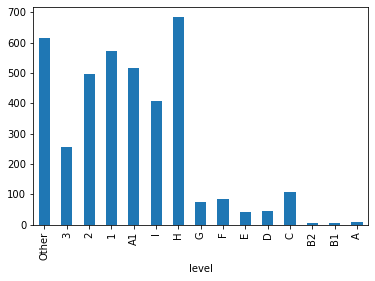

In [255]:
ax = r['days'].count().plot(kind = 'bar')
ax.set_xticklabels(classes)
print('')

,count,mean,std,min,25%,50%,75%,max
level,,,,,,,,
0,592.0,1.060883e+06,3.833610e+06,0.0,0.0,200000.0,1000000.0,50000000.0
1,253.0,9.144269e+04,2.848231e+05,0.0,30000.0,50000.0,50000.0,3700000.0
2,491.0,1.999489e+05,4.856116e+05,0.0,0.0,50000.0,150000.0,6050000.0
3,562.0,2.807235e+05,5.468790e+05,0.0,50000.0,100000.0,287500.0,5050000.0
4,497.0,2.424441e+05,5.334816e+05,0.0,0.0,0.0,200000.0,4500000.0
5,391.0,7.853836e+05,9.962760e+05,0.0,200000.0,500000.0,1000000.0,6000000.0
6,626.0,1.411454e+06,2.741623e+06,0.0,200000.0,700000.0,1600000.0,50000000.0
7,65.0,2.285692e+06,3.135048e+06,0.0,500000.0,1300000.0,2600000.0,20000000.0
8,71.0,2.443662e+06,2.968332e+06,0.0,550000.0,1600000.0,3250000.0,20000000.0


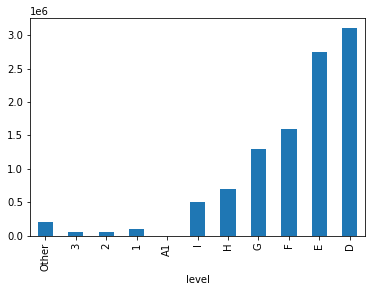

In [276]:
slow = sCompleted[sCompleted['level']<11]
rlow = slow.groupby(['level'])
bx = rlow['sbond_amount'].median().plot(kind = 'bar')
bx.set_xticklabels(classes[:11])
print('')
rlow['sbond_amount'].describe()

In [274]:
x = sCompleted[sCompleted['level']==6]
x

,name,race,gender,days,level,class,sbond_amount,ubond_amount,nobond,violent,drugs,dwi,theft,violation
defendant_id,,,,,,,,,,,,,,
8750,"BRADY, TERRY REUBEN",W,M,1.0,6,H,500000,0,1,2,0,0,1,0
9276,"GIARDINELLI, GIDEON JOSEPH",W,M,26.0,6,H,2300000,0,0,1,3,0,0,0
9392,"MCCLAIN, TIERRA UNIQUE",B,F,2.0,6,H,200000,0,0,0,2,0,0,0
9397,"MCMAHAN, ROBERT HAROLD",W,M,77.0,6,H,1000000,0,0,1,0,0,0,0
9472,"ROGERS, BRIAN GERALD",W,M,3.0,6,H,0,1000000,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168194,"BAME, SUSAN REID",W,F,2.0,6,H,400000,0,0,0,0,0,1,0
168416,"MONTEITH, MATTHEW ALAN",W,M,2.0,6,H,1000000,0,0,0,0,0,4,0
168737,"KEEFER, ROBERT STEVEN",W,M,1.0,6,H,5000000,0,0,1,0,0,0,0
